# Task 1: Basics - loading data, visualization, segmentation, filtering

## 1.1 Loading data and filtering it

The processing order for optical motion capture data is usually as follows:
1. Record OMC data (marker trajectories) + force plate data (ground reaction forces)
2. Label markers and fill gaps in the marker trajectories (already done for you)
3. Scale musculoskeletal model to the subject (more info [here](https://opensimconfluence.atlassian.net/wiki/spaces/OpenSim/pages/53089741/Tutorial+3+-+Scaling+Inverse+Kinematics+and+Inverse+Dynamics))
4. Inverse kinematics: calculate joint angles from marker trajectories
5. Filter marker trajectories and joint angles -- to remove high-frequency noise. Always filter whole trajectories, not only segments ()
6. Inverse dynamics: calculate joint moments from joint angles and ground reaction forces

**To Do:**

Go to filter.py and implement a 4th zero-lag Butterworth low-pass filter with a cutoff frequency of 6 Hz. You can use the scipy functions `scipy.signal.butter` and `scipy.signal.filtfilt` for this.

Then run the next cell to visualize the effect of filtering on the marker trajectories. You should see that high-frequency noise is removed, but the overall shape of the signal is preserved.

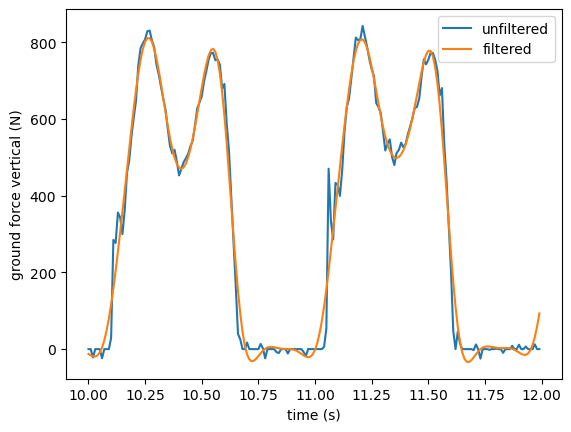

In [1]:
from utils import *
from utils import load_data, filter
import matplotlib.pyplot as plt

grf_data = load_data.load_grf_data()
filtered_grf_data = filter.butterworth_lowpass_filter(grf_data, cutoff=6, fs=100, order=4)
range_ = slice(1000, 1200)
plt.plot(grf_data['time'][range_], grf_data['ground_force_vy'][range_], label='unfiltered')
plt.plot(filtered_grf_data['time'][range_], filtered_grf_data['ground_force_vy'][range_], label='filtered')
plt.xlabel('time (s)')
plt.ylabel('ground force vertical (N)')
plt.legend()


Run `pytest tests.py` to check if the first part of your implementation is correct - 2 tests should pass now.

## 1.2 Segmenting gait cycles
We can use the vertical ground reaction force (GRF) to identify heel strikes and toe offs. A common threshold is 20 N: if the vertical GRF exceeds this value, the foot is on the ground. Always use the unfiltered GRF data for this.

Next cell plots the points we roughly search for:

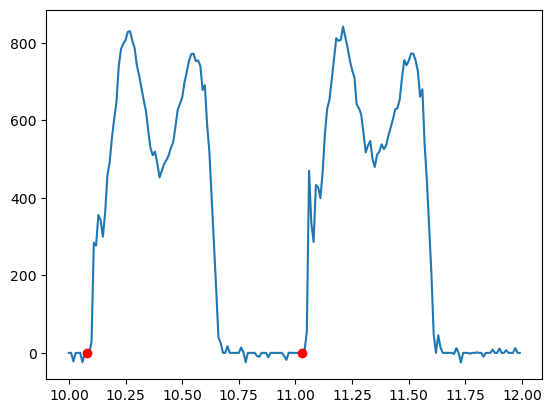

In [2]:
import matplotlib.pyplot as plt

plt.plot(grf_data['time'][range_], grf_data['ground_force_vy'][range_], label='unfiltered')
plt.plot([10.08], [0], 'ro', label='heel strike 1')
plt.plot([11.03], [0], 'ro', label='heel strike 2')

**To Do:**

Now, implement the function `segment_gait_cycles` in `utils/segment.py` that segments the data into individual gait cycles based on heel strikes. Use a threshold of 60 N on the unfiltered vertical ground reaction force to identify heel strikes. The function should also clean the data: remove gait cycles that do not reach a minimum force of 300 N (to remove partial steps, noise outliers, etc.). Then, remove all gait cycles that are +- 2 standard deviations away from the mean gait cycle duration (to remove outliers). The function should return a list of data frames, each containing one gait cycle. 

Then execute the next cell to see all gait cycles overlaid. Do you see a clear pattern as in the lecture slides?

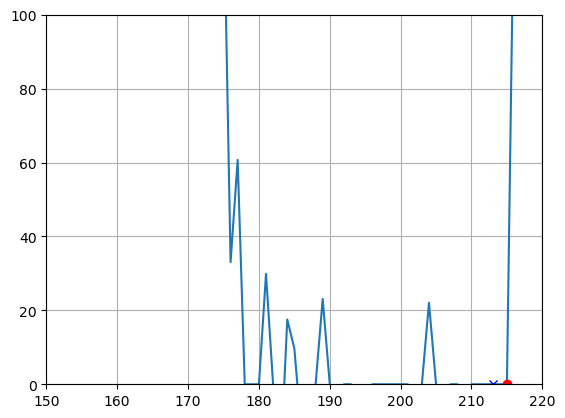

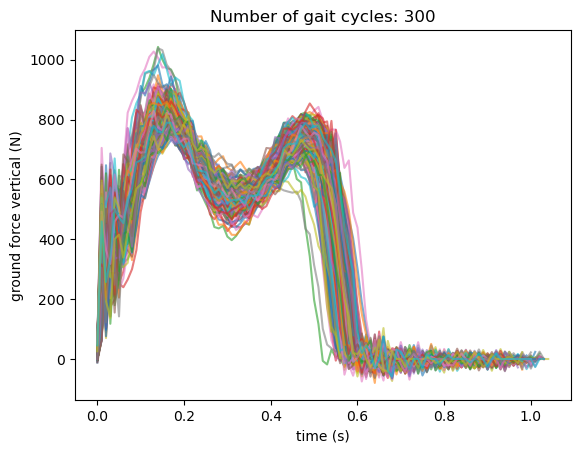

In [3]:
%load_ext autoreload
%autoreload 2
from utils import segment

gait_cycles = segment.segment_gait_cycles(
    grf_data['ground_force_vy'], data=grf_data, threshold=60, fs=100
)

for cycle in gait_cycles:
    plt.plot(cycle['time'], cycle['ground_force_vy'], alpha=0.6)

plt.xlabel('time (s)')
plt.ylabel('ground force vertical (N)')
plt.title(f'Number of gait cycles: {len(gait_cycles)}')
plt.show()

## 1.3 Ensemble averaging gait cycles

**To Do:**

Implement a function `ensemble_average` in `utils/segment.py` that takes a list of data frames (gait cycles) and returns the ensemble average and standard deviation. The function should first resample each gait cycle to 100 data points (using linear interpolation), then calculate the mean and standard deviation across all cycles.

Then execute the next cell to visualize the ensemble average and standard deviation of the vertical ground reaction force across all gait cycles. You should see a smooth curve representing the average GRF pattern during walking, with shaded areas indicating variability across cycles.

This should look like the plots in the lecture slides.

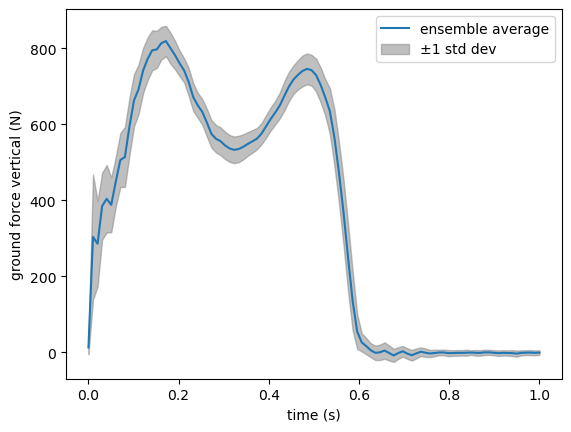

In [4]:
ensemble_average, ensemble_std = segment.ensemble_average(
    [cycle[["time", "ground_force_vy"]] for cycle in gait_cycles]
)

plt.plot(ensemble_average["time"], ensemble_average["ground_force_vy"], label="ensemble average")
plt.fill_between(
    ensemble_average["time"],
    ensemble_average["ground_force_vy"] - ensemble_std["ground_force_vy"],
    ensemble_average["ground_force_vy"] + ensemble_std["ground_force_vy"],
    color="gray", alpha=0.5, label="±1 std dev"
)
plt.xlabel("time (s)")
plt.ylabel("ground force vertical (N)")
plt.legend()
plt.show()

If that all worked, check out the test function again: `pytest tests.py` - 1 more test should pass now!

## 1.4 To do: Visualize joint angles
**To Do:**

Visualize the following ensemble averages with standard deviations:
- Hip flexion/extension
- Knee flexion/extension
- Ankle dorsiflexion/plantarflexion
- Ground reaction force (horizontal and vertical)
Make it look nice (labels, legends, etc.) and compare to the plots in the lecture slides. Do they look similar?

In [5]:
from utils import load_data

# Load all data files (you already have data/Trial1_kinematics.mot)
marker_data = load_data.load_marker_data()
grf_data = load_data.load_grf_data()
kinematics_data = load_data.load_kinematics_data()

print("Data loaded successfully:")
print(f"Markers: {marker_data.shape}")
print(f"GRF: {grf_data.shape}")
print(f"Kinematics: {kinematics_data.shape}")

 Loaded marker data with 138 columns starting from line 3
First 15 columns: ['Frame', 'Time', 'C7_X', 'C7_Y', 'C7_Z', 'CLAV_X', 'CLAV_Y', 'CLAV_Z', 'LANK_X', 'LANK_Y', 'LANK_Z', 'LASI_X', 'LASI_Y', 'LASI_Z', 'LBHD_X']
Data loaded successfully:
Markers: (29999, 138)
GRF: (29998, 19)
Kinematics: (29997, 38)


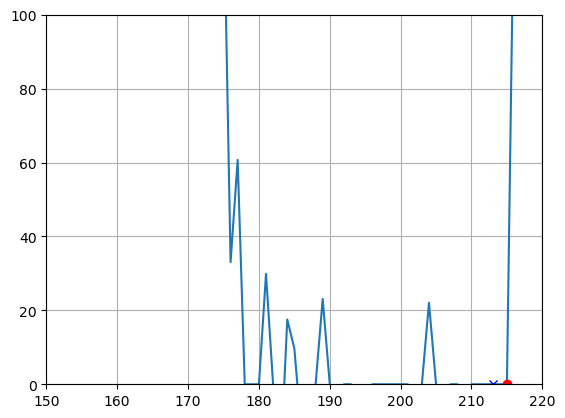

[     time  pelvis_tilt  pelvis_list  pelvis_rotation  pelvis_tx  pelvis_ty  \
 337  0.00    -0.060162    -0.000033         0.014386  -0.057238   0.898663   
 338  0.01    -0.056243     0.006445         0.014174  -0.055756   0.897976   
 339  0.02    -0.053232     0.014091         0.014495  -0.054234   0.897446   
 340  0.03    -0.051543     0.022633         0.015162  -0.052682   0.897050   
 341  0.04    -0.051281     0.031781         0.016058  -0.051129   0.896785   
 ..    ...          ...          ...              ...        ...        ...   
 434  0.97    -0.052355    -0.037113        -0.020742  -0.049475   0.899688   
 435  0.98    -0.051347    -0.034994        -0.027086  -0.048389   0.898152   
 436  0.99    -0.050338    -0.031034        -0.032187  -0.047033   0.896717   
 437  1.00    -0.049087    -0.025026        -0.035940  -0.045383   0.895419   
 438  1.01    -0.047368    -0.016922        -0.038320  -0.043463   0.894316   
 
      pelvis_tz  hip_flexion_r  hip_adduction_r  h

In [6]:
segment.segment_gait_cycles(
    grf_data["ground_force_vy"], data=kinematics_data, threshold=60, fs=100
)

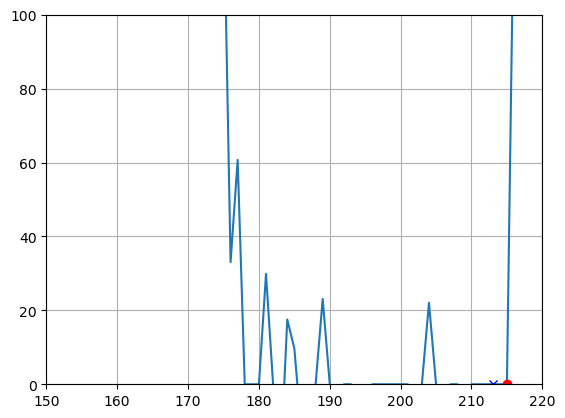

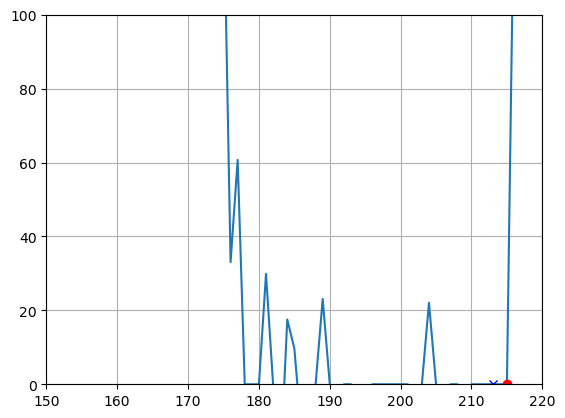

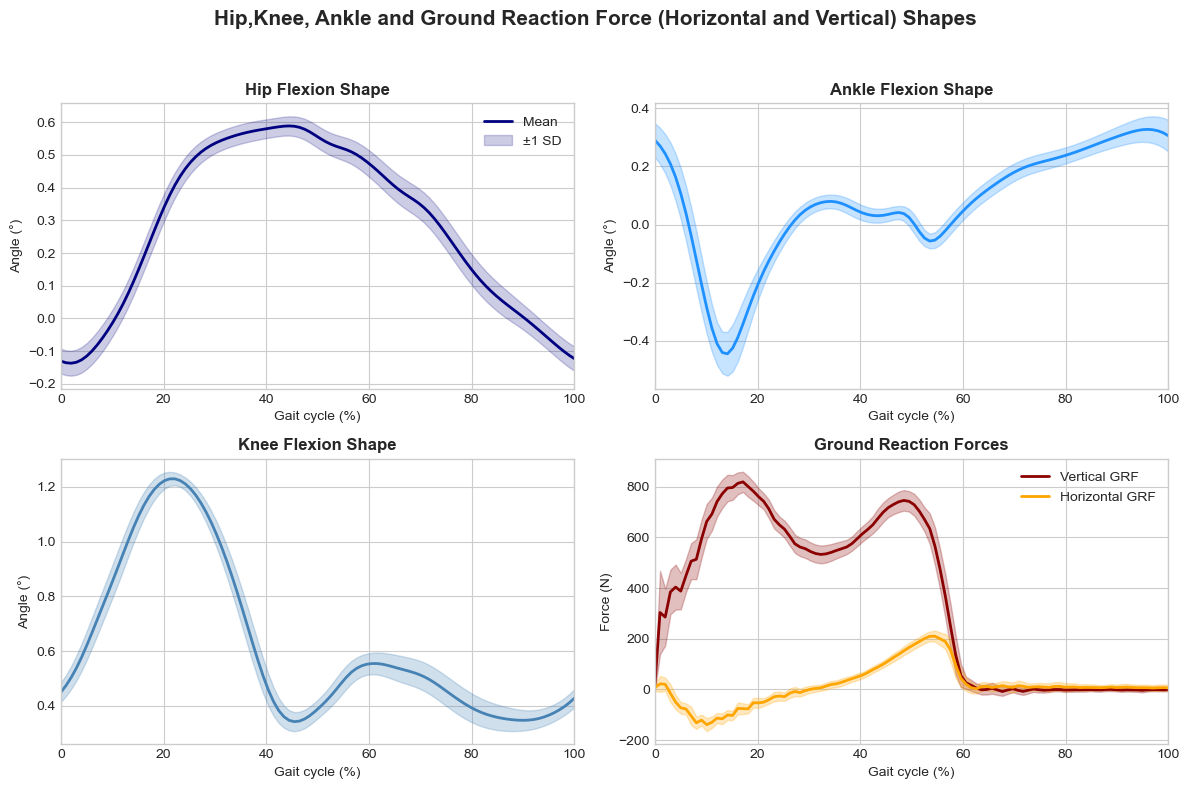

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from utils import segment, load_data

#Step 1: Load datasets
kinematics_data = load_data.load_kinematics_data()
grf_data = load_data.load_grf_data()

#Step 2: Segment GRF data to find heel strikes
gait_cycles_grf = segment.segment_gait_cycles(
    grf_data["ground_force_vy"], data=grf_data, threshold=60, fs=100
)

gait_cycles_kinematics = segment.segment_gait_cycles(
    grf_data["ground_force_vy"], data=kinematics_data, threshold=60, fs=100
)


#Step 4: Compute ensemble averages using correct column names

#From my column list: 'hip_flexion_r', 'knee_angle_r', 'ankle_angle_r'

hip_avg, hip_std = segment.ensemble_average(
    [c[["time", "hip_flexion_r"]] for c in gait_cycles_kinematics]
)
knee_avg, knee_std = segment.ensemble_average(
    [c[["time", "knee_angle_r"]] for c in gait_cycles_kinematics]
)
ankle_avg, ankle_std = segment.ensemble_average(
    [c[["time", "ankle_angle_r"]] for c in gait_cycles_kinematics]
)
grf_v_avg, grf_v_std = segment.ensemble_average(
    [c[["time", "ground_force_vy"]] for c in gait_cycles_grf]
)
grf_h_avg, grf_h_std = segment.ensemble_average(
    [c[["time", "ground_force_vx"]] for c in gait_cycles_grf]
)

#Step 5: Plot results (slide-like style)
plt.style.use("seaborn-v0_8-whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Hip,Knee, Ankle and Ground Reaction Force (Horizontal and Vertical) Shapes", fontsize=15, fontweight="bold")

# Hip
axs[0, 0].plot(hip_avg["time"] * 100, hip_avg["hip_flexion_r"], color="navy", linewidth=2, label="Mean")
axs[0, 0].fill_between(hip_avg["time"] * 100,
                       hip_avg["hip_flexion_r"] - hip_std["hip_flexion_r"],
                       hip_avg["hip_flexion_r"] + hip_std["hip_flexion_r"],
                       color="navy", alpha=0.2, label="±1 SD")
axs[0, 0].set_title("Hip Flexion Shape", fontsize=12, fontweight="bold")
axs[0, 0].set_xlabel("Gait cycle (%)"); axs[0, 0].set_ylabel("Angle (°)")
axs[0, 0].set_xlim(0, 100); axs[0, 0].legend(loc="upper right")

# Knee
axs[1, 0].plot(knee_avg["time"] * 100, knee_avg["knee_angle_r"], color="steelblue", linewidth=2)
axs[1, 0].fill_between(knee_avg["time"] * 100,
                       knee_avg["knee_angle_r"] - knee_std["knee_angle_r"],
                       knee_avg["knee_angle_r"] + knee_std["knee_angle_r"],
                       color="steelblue", alpha=0.25)
axs[1, 0].set_title("Knee Flexion Shape", fontsize=12, fontweight="bold")
axs[1, 0].set_xlabel("Gait cycle (%)"); axs[1, 0].set_ylabel("Angle (°)")
axs[1, 0].set_xlim(0, 100)

# Ankle
axs[0, 1].plot(ankle_avg["time"] * 100, ankle_avg["ankle_angle_r"], color="dodgerblue", linewidth=2)
axs[0, 1].fill_between(ankle_avg["time"] * 100,
                       ankle_avg["ankle_angle_r"] - ankle_std["ankle_angle_r"],
                       ankle_avg["ankle_angle_r"] + ankle_std["ankle_angle_r"],
                       color="dodgerblue", alpha=0.25)
axs[0, 1].set_title("Ankle Flexion Shape", fontsize=12, fontweight="bold")
axs[0, 1].set_xlabel("Gait cycle (%)"); axs[0, 1].set_ylabel("Angle (°)")
axs[0, 1].set_xlim(0, 100)

# Ground Reaction Forces
axs[1, 1].plot(grf_v_avg["time"] * 100, grf_v_avg["ground_force_vy"], color="darkred", linewidth=2, label="Vertical GRF")
axs[1, 1].fill_between(grf_v_avg["time"] * 100,
                       grf_v_avg["ground_force_vy"] - grf_v_std["ground_force_vy"],
                       grf_v_avg["ground_force_vy"] + grf_v_std["ground_force_vy"],
                       color="darkred", alpha=0.25)
axs[1, 1].plot(grf_h_avg["time"] * 100, grf_h_avg["ground_force_vx"], color="orange", linewidth=2, label="Horizontal GRF")
axs[1, 1].fill_between(grf_h_avg["time"] * 100,
                       grf_h_avg["ground_force_vx"] - grf_h_std["ground_force_vx"],
                       grf_h_avg["ground_force_vx"] + grf_h_std["ground_force_vx"],
                       color="orange", alpha=0.25)
axs[1, 1].set_title("Ground Reaction Forces", fontsize=12, fontweight="bold")
axs[1, 1].set_xlabel("Gait cycle (%)"); axs[1, 1].set_ylabel("Force (N)")
axs[1, 1].set_xlim(0, 100); axs[1, 1].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
